# Attempt to do some Bayesian forecasting

* Used the work done on:
    * https://towardsdatascience.com/forecasting-with-bayesian-dynamic-generalized-linear-models-in-python-865587fbaf90

In [21]:
import sys
sys.path.append("../")
from Hack import load
from Hack.rl import get_expected_price as get_ep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybats
from pybats.loss_functions import MAPE
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import *

In [15]:
#Load the data
epex = load.epex().load()

In [ ]:
forecast_start = 0
forecast_end = 500
length=forecast_end-forecast_start
indexs=np.arange(forecast_start,forecast_end)
prices=epex.values[forecast_start:forecast_end,0]

mod, samples = analysis(Y = prices, X=indexs, family='poisson',
    forecast_start=forecast_start,      
    forecast_end=forecast_end,         
    k=k,
    ntrend=1,                   # Intercept and slope in model
    nsamps=5000,                # Number of samples taken in the Poisson process
    seasPeriods=[48],           # Length of the seasonal variations in the data - i.e. every 24hr here
    seasHarmComponents=[[1,2]], # To pick out the half dayly and daily harmonics
    prior_length=prior_size,    # How many data points to use in defining prior - i.e. 48 = one day
    deltrend=0.94,              # Discount factor on the intercept parameter
    delregn=0.90,               # Discount factor on the regression parameters
    delVar=0.98,
    delSeas=0.98,
    rho=.6, # Random effect to increase variance
    )

In [94]:
def bayes_forecast(iv,dv,start,prior_size=48):
    '''
    This functions runs the Pybats algorithm by taking two parameters: an independent variable matrix and a dependent variable. 
    Both elements must be sequential time series. 
    '''
    # first check if the iv = None, indicating this would be a univariate series
    if iv is None:
        x = None
    else:
        x = iv
    y = dv

    if prior_size>start:
        raise Exception('Warning: must start longer than the priorsize')
    
    # set the one-step-ahead value; by default we want 1
    k = 1                                                       
    forecast_start = start                            
    forecast_end = len(y)-1
    mod, samples = analysis(Y=y, X=x, family='poisson',
        forecast_start=forecast_start,      
        forecast_end=forecast_end,         
        k=k,
        ntrend=1,                   # Intercept and slope in model
        nsamps=5000,                # Number of samples taken in the Poisson process
        seasPeriods=[48],           # Length of the seasonal variations in the data - i.e. every 24hr here
        seasHarmComponents=[[1,2]], # To pick out the half dayly and daily harmonics
        prior_length=prior_size,    # How many data points to use in defining prior - i.e. 48 = one day
        deltrend=0.94,              # Discount factor on the intercept parameter
        delregn=0.90,               # Discount factor on the regression parameters
        delVar=0.98,
        delSeas=0.98,
        rho=.6, # Random effect to increase variance
        )
    forecast = median(samples)
    
    # set confidence interval for in-sample forecast
    credible_interval=95
    alpha = (100-credible_interval)/2
    upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
    lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
    print("MAPE:", MAPE(y[-18:], forecast[-18:]).round(2))
    
    #Generate the Bayesian Future Forecast
    return mod, forecast, samples, y


In [97]:
index_start=0
index_stop=500
length=index_stop-index_start

indexs=np.arange(np.size(epex.values[index_start:index_stop,0]))
prices=epex.values[index_start:index_stop,0]
median_prices = np.zeros_like(prices)
for i,val in enumerate(median_prices):
    median_prices[i]=get_ep(prices,i,mode='median')

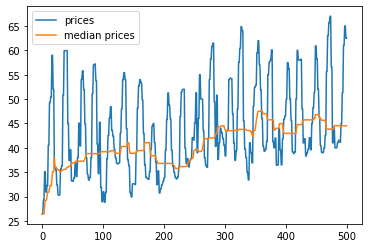

In [83]:
plt.plot(indexs[index_start:index_stop],prices[index_start:index_stop],label='prices')
plt.plot(indexs[index_start:index_stop],median_prices[index_start:index_stop],label='median prices')
plt.legend()

In [98]:
for_start=50
mv_mod, mv_for, mv_samp, mv_y = bayes_forecast(indexs,prices,for_start)

beginning forecasting
MAPE: 12.89


(0.0, 95.0)

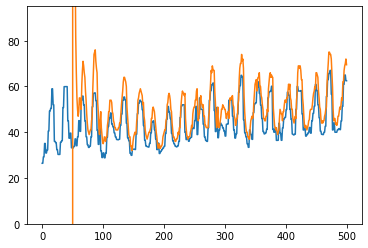

In [100]:
plt.plot(indexs[index_start:index_stop],prices[index_start:index_stop],label='actual median')
plt.plot(indexs[index_start+for_start:index_stop],mv_for,label='Bayesian forecast')
upper=2*np.max(median_prices[index_start:index_stop])
plt.ylim([0,upper])

In [40]:
mv_samp

array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [-2.14748365e+09],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [-2.14748365e+09],
        [-2.14748365e+09]],

       ...,

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        ...,
        